![](https://policyoptions.irpp.org/wp-content/uploads/sites/2/2020/07/Facebook-WHO%E2%80%99s-COVID-19-Technology-Access-Pool-deserves-Canada%E2%80%99s-support.jpg)

## Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
import random
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import Model

## Extracting Files

In [2]:
c = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID'
n = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal'
p = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia'

In [3]:
random.seed(42)
filenames = os.listdir(c) + random.sample(os.listdir(n), 5000) + os.listdir(p)

### Classes
* 0 -> Normal
* 1 -> Viral Pneumonia
* 2 -> COVID

In [4]:
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append(str(2))
    elif category == 'Viral Pneumonia':
        categories.append(str(1))
    else:
        categories.append(str(0))

## Converting to Dataframe

In [5]:
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    elif 'Viral Pneumonia' in filenames[i]:
        filenames[i] = os.path.join(p, filenames[i])
    else:
        filenames[i] = os.path.join(n, filenames[i])
    
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
df.head()

,filename,category
0,../input/covid19-radiography-database/COVID-19...,2
1,../input/covid19-radiography-database/COVID-19...,2
2,../input/covid19-radiography-database/COVID-19...,2
3,../input/covid19-radiography-database/COVID-19...,2
4,../input/covid19-radiography-database/COVID-19...,2


## Exploratory Data Analysis

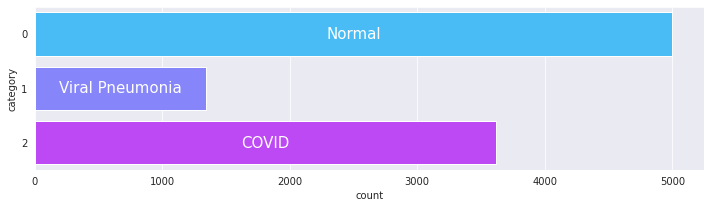

In [7]:
plt.figure(figsize=(12,3))
splot = sns.countplot(data = df.sort_values(by='category'), y ='category', palette='cool', saturation=0.9)
plt.bar_label(container=splot.containers[0], 
              labels=['Normal', 'Viral Pneumonia', 'COVID'], 
              label_type='center', size=15, color='w')
plt.show()

## Data Visualization

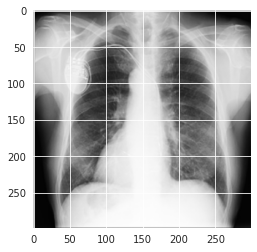

In [8]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)
plt.show()

## Splitting Train, Validation & Test Data

In [9]:
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [10]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

## Data Augmentation

In [11]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [12]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 7968 validated image filenames belonging to 3 classes.


In [13]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 997 validated image filenames belonging to 3 classes.


## Model Training - VGG16

#### Model Architecture

In [14]:
baseModel = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in baseModel.layers:
    layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(3, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

2022-01-11 14:28:11.562510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 14:28:11.700627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 14:28:11.701677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 14:28:11.703212: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

58900480/58889256 [==============================] - 1s 0us/step


#### Model Summary

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### Optimizer - Adam

In [16]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
epochs = 50
history = model.fit_generator(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=epochs)

2022-01-11 14:28:16.364929: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-01-11 14:28:18.483539: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


532/532 [==============================] - 165s 294ms/step - loss: 0.6224 - accuracy: 0.7408 - val_loss: 0.4715 - val_accuracy: 0.7944
Epoch 2/50
532/532 [==============================] - 116s 218ms/step - loss: 0.4397 - accuracy: 0.8248 - val_loss: 0.3470 - val_accuracy: 0.8616
Epoch 3/50
532/532 [==============================] - 116s 218ms/step - loss: 0.3825 - accuracy: 0.8454 - val_loss: 0.3755 - val_accuracy: 0.8395
Epoch 4/50
532/532 [==============================] - 118s 222ms/step - loss: 0.3427 - accuracy: 0.8609 - val_loss: 0.3678 - val_accuracy: 0.8465
Epoch 5/50
532/532 [==============================] - 117s 221ms/step - loss: 0.3280 - accuracy: 0.8687 - val_loss: 0.2663 - val_accuracy: 0.8957
Epoch 6/50
532/532 [==============================] - 118s 221ms/step - loss: 0.3097 - accuracy: 0.8756 - val_loss: 0.2974 - val_accuracy: 0.8766
Epoch 7/50
532/532 [==============================] - 119s 223ms/step - loss: 0.2987 - accuracy: 0.8813 - val_loss: 0.2362 - val_accura

## Saving Model

In [18]:
model.save('Covid.h5')

## Plotting 
* Training & Validation Loss
* Training & Validation Loss

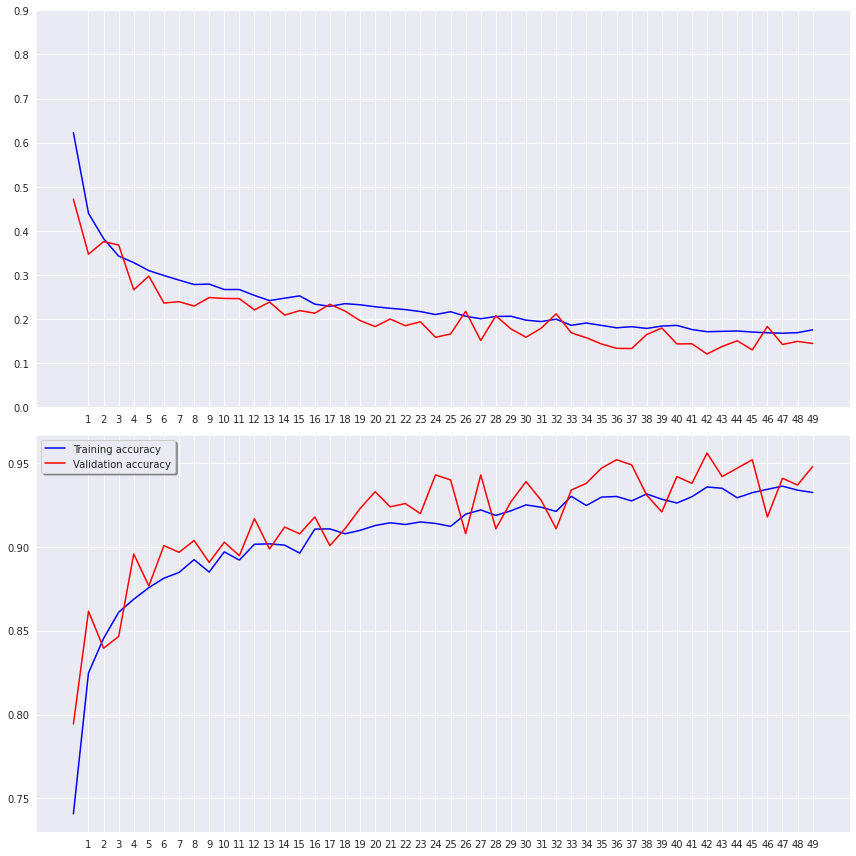

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Model Testing

True value is : Normal
Prediction is:
Viral Pneumonia


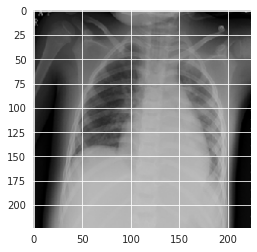

In [20]:
sample = random.choice(test_data['filename'])


category = sample.split('-')[0]
true = ''
if category == 'COVID':
    true = 'COVID'
elif category == 'Viral Pneumonia':
    true = 'Viral Pneumonia'
else:
    true = 'Normal'

print(f'True value is : {true}')
    
image = load_img(sample, target_size=(224, 224))
img = img_to_array(image)
img = img.reshape((1, 224, 224, 3))

result = model.predict(img)
result = np.argmax(result, axis=-1)
print('Prediction is:')
if result == 0:
    print("Normal")
elif result == 1:
    print("Viral Pneumonia")
else:
    print("COVID +")
    
plt.imshow(image)